# Project - Classification of Human Activities

Disciplina de Tópicos de Ciência de Dados

Joana Simões, nº 2019217013

In [41]:
# imports 
from sklearn.model_selection import train_test_split, KFold
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import recall_score, precision_score, f1_score
import pandas as pd
from sklearn import preprocessing
import os

In [56]:
import warnings
warnings.filterwarnings("ignore")

## Exercise 1.1

In [2]:
def split_train_test(X, y, percentage_test=0.3):
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=percentage_test, random_state=42)
    return x_train, x_test, y_train, y_test

In [3]:
def split_train_test_validation(X, y, percentage_test=0.3, percentage_validation=0.3):
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=percentage_test, random_state=42)
    percent = (len(X)*percentage_validation) / len(x_train)
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=percent)

    return x_train, x_val, x_test, y_train, y_val, y_test

In [4]:
def split_k_fold(X, y, k_folds):
    x_train = []
    x_test = []
    y_train = []
    y_test = []

    k_fold = KFold(n_splits=k_folds, random_state=42, shuffle=True)

    for train_index, test_index in k_fold.split(X):
        x_train.append(X.loc[train_index])
        y_train.append(y[train_index])
        x_test.append(X.loc[test_index])
        y_test.append(y[test_index])

    return x_train, x_test, y_train, y_test

## Exercise 1.2

In [5]:
def display_confusion_matrix(cm, labels, title=''):
    plt.figure()
    display = ConfusionMatrixDisplay(cm, display_labels=labels)
    display.plot()
    plt.title(title)
    plt.show()

In [6]:
def calculate_confusion_matrix(y, y_pred, labels=None, display=True, title=''):
    cm = confusion_matrix(y, y_pred, labels=labels)
    if display:
        display_confusion_matrix(cm, labels, title=title)
    return cm

In [7]:
def calculate_recall(y, y_pred, metric=None):
    score = recall_score(y, y_pred, average=metric)
    return score

In [8]:
def calculate_precision(y, y_pred, metric=None):
    return precision_score(y, y_pred, average=metric)

In [9]:
def calculate_f1(y, y_pred, metric=None):
    return f1_score(y, y_pred, average=metric)

In [10]:
def plot_measures(recalls, precisions, f1_scores, title=''):
    plt.figure()
    x = np.arange(len(recalls))+1
    plt.plot(x, recalls, label='Recall')
    plt.plot(x, precisions, label='Precision')
    plt.plot(x, f1_scores, label='F1 score')
    plt.xlabel('K values')
    plt.ylabel('Result')
    plt.title(title)
    plt.legend()
    plt.show()

## Exercise 2 -Test TTS e CV with KNN

In [11]:
from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier

In [13]:
def load_dataset():
    iris_dataset = datasets.load_iris(as_frame=True)
    X = iris_dataset.data
    y = iris_dataset.target
    target_names = iris_dataset.target_names
    return X, y, target_names

In [56]:
X, y, target_names = load_dataset()

In [16]:
X.shape

(150, 4)

### Train-only : k=1

In [17]:
model = KNeighborsClassifier(n_neighbors = 1)
model.fit(X,  y)
y_pred = model.predict(X)

Recall: 1.0
Precision: 1.0
F1 score: 1.0


<Figure size 640x480 with 0 Axes>

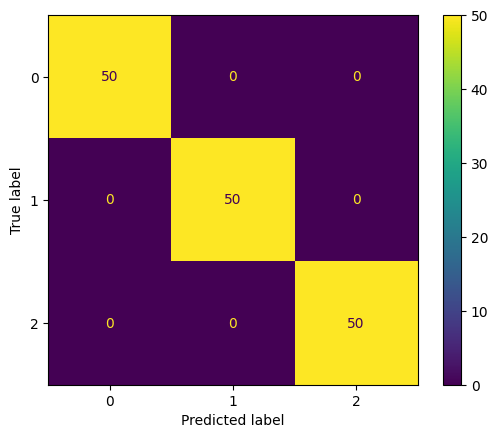

array([[50,  0,  0],
       [ 0, 50,  0],
       [ 0,  0, 50]], dtype=int64)

In [18]:
print('Recall:', calculate_recall(y, y_pred, 'weighted'))
print('Precision:',calculate_precision(y, y_pred, 'weighted'))
print('F1 score:',calculate_f1(y, y_pred, 'weighted'))
calculate_confusion_matrix(y, y_pred)

### Train-test 70-30 - k=1

In [19]:
x_train, x_test, y_train, y_test = split_train_test(X, y, 0.3)

Recall: 1.0
Precision: 1.0
F1 score: 1.0


<Figure size 640x480 with 0 Axes>

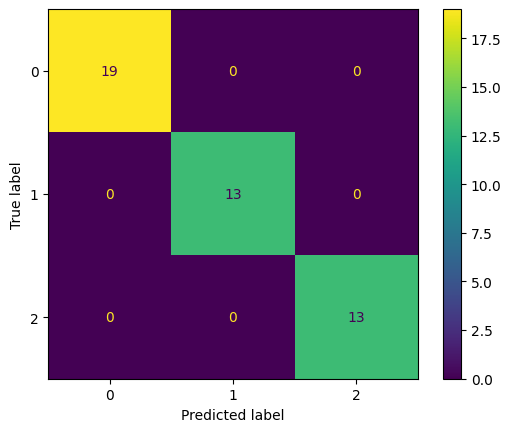

array([[19,  0,  0],
       [ 0, 13,  0],
       [ 0,  0, 13]], dtype=int64)

In [20]:
model = KNeighborsClassifier(n_neighbors=1)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
print('Recall:', calculate_recall(y_test, y_pred, 'weighted'))
print('Precision:',calculate_precision(y_test, y_pred, 'weighted'))
print('F1 score:',calculate_f1(y_test, y_pred, 'weighted'))
calculate_confusion_matrix(y_test, y_pred)

### 10CV - k=1

In [21]:
def cross_validation_test(iters, X, y, k_folds=10):
    iters_recalls = []
    iters_precisions = []
    iters_f1_scores = []
    x_train, x_test, y_train, y_test = split_k_fold(X, y, k_folds)
    for iter in range(iters):
        recalls = []
        precisions = []
        f1_scores = []
        for i in range(len(x_train)):
            model = KNeighborsClassifier(n_neighbors=iter+1)
            model.fit(x_train[i], y_train[i])
            y_pred = model.predict(x_test[i])

            recalls.append(calculate_recall(y_test[i], y_pred))
            precisions.append(calculate_precision(y_test[i], y_pred))
            f1_scores.append(calculate_f1(y_test[i], y_pred))
        r_mean = np.mean(recalls)
        p_mean = np.mean(precisions)
        f_mean = np.mean(f1_scores)
        print(f'********* Averages - k={iter+1} **********')
        print('Recall:', r_mean)
        print('Precision:',p_mean)
        print('F1 Score:', f_mean)

        iters_recalls.append(r_mean)
        iters_precisions.append(p_mean)
        iters_f1_scores.append(f_mean)
    if iters > 1:
        plot_measures(iters_recalls, iters_precisions, iters_f1_scores)
        print('Best k')
        print('Recall: ', np.argmax(iters_recalls)+1)
        print('Precision: ', np.argmax(iters_precisions)+1)
        print('F1-Score: ', np.argmax(iters_f1_scores)+1)
        return np.argmax(f1_scores)+1
    return None


In [22]:
bests = cross_validation_test(1, X, y)

********* Averages - k=1 **********
Recall: 0.9607936507936509
Precision: 0.9615079365079366
F1 Score: 0.9588337588337589


In [23]:
def avg_confusion_matrix(confusion_matrices, display=True):
    avg_cm = confusion_matrices[0]
    for i in range(1, len(confusion_matrices)):
        avg_cm += confusion_matrices[i]
    avg_cm = avg_cm / len(confusion_matrices)
    if display:
        display_confusion_matrix(avg_cm, None)
    return avg_cm

### Train only - multiple k values

In [24]:
def train_only_test(iters, X, y):
    recalls = []
    precisions = []
    f1_scores = []
    for i in range(15):
        model = KNeighborsClassifier(n_neighbors = i+1)
        model.fit(X, y)
        y_pred = model.predict(X)
        recall = calculate_recall(y, y_pred, 'weighted')
        recalls.append(recall)
        precision = calculate_precision(y, y_pred,  'weighted')
        precisions.append(precision)
        f1 = calculate_f1(y, y_pred,  'weighted')
        f1_scores.append(f1)
        print(f'********* Averages - k={i+1} **********')
        print('Recall:', recall)
        print('Precision:',precision)
        print('F1 Score:', f1)
    if iters > 1:
        plot_measures(recalls, precisions, f1_scores)
        print('Best k')
        print('Recall: ', np.argmax(recalls)+1)
        print('Precision: ', np.argmax(precisions)+1)
        print('F1-Score: ', np.argmax(f1_scores)+1)
        return np.argmax(f1_scores)+1

********* Averages - k=1 **********
Recall: 1.0
Precision: 1.0
F1 Score: 1.0
********* Averages - k=2 **********
Recall: 0.98
Precision: 0.9811320754716981
F1 Score: 0.9799819837854068
********* Averages - k=3 **********
Recall: 0.96
Precision: 0.96
F1 Score: 0.96
********* Averages - k=4 **********
Recall: 0.96
Precision: 0.96
F1 Score: 0.96
********* Averages - k=5 **********
Recall: 0.9666666666666667
Precision: 0.9667867146858743
F1 Score: 0.9666633329999667
********* Averages - k=6 **********
Recall: 0.9733333333333334
Precision: 0.9733333333333334
F1 Score: 0.9733333333333334
********* Averages - k=7 **********
Recall: 0.9733333333333334
Precision: 0.9738247863247864
F1 Score: 0.9733226623982927
********* Averages - k=8 **********
Recall: 0.98
Precision: 0.980125383486728
F1 Score: 0.9799979997999799
********* Averages - k=9 **********
Recall: 0.98
Precision: 0.980125383486728
F1 Score: 0.9799979997999799
********* Averages - k=10 **********
Recall: 0.98
Precision: 0.980125383486

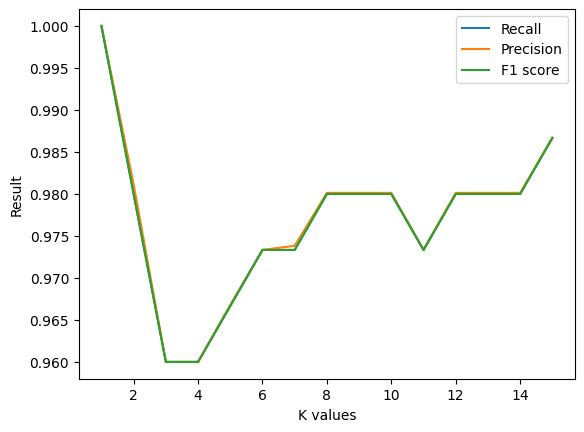

Best k
Recall:  1
Precision:  1
F1-Score:  1


In [25]:
best_k_train_only = train_only_test(15, X, y)

In [26]:
model = KNeighborsClassifier(n_neighbors=best_k_train_only)
model.fit(X, y)
y_pred = model.predict(X)

Recall: 1.0
Precision: 1.0
F-Score: 1.0


<Figure size 640x480 with 0 Axes>

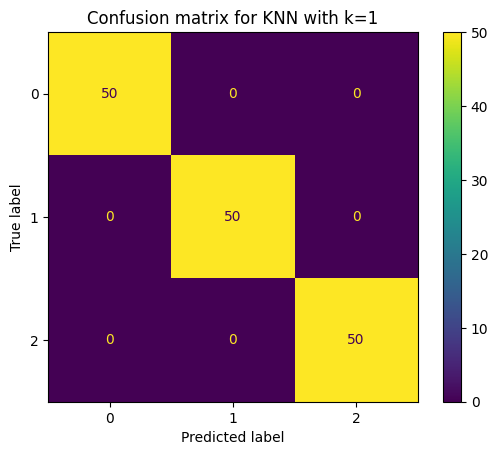

array([[50,  0,  0],
       [ 0, 50,  0],
       [ 0,  0, 50]], dtype=int64)

In [27]:
print('Recall:', calculate_recall(y, y_pred, 'weighted'))
print('Precision:', calculate_precision(y, y_pred, 'weighted'))
print('F-Score:', calculate_f1(y, y_pred, 'weighted'))
calculate_confusion_matrix(y, y_pred, title=f'Confusion matrix for KNN with k={best_k_train_only}')

### TVT 40-30-30 - multiple k values

In [28]:
x_train, x_val, x_test, y_train, y_val, y_test = split_train_test_validation(X, y)

In [29]:
def tvt_test(iters, x_train, x_val, y_train, y_val):
    recalls = []
    precisions = []
    f1_scores = []
    for i in range(iters):
        model = KNeighborsClassifier(n_neighbors=i+1)
        model.fit(x_train, y_train)
        y_pred = model.predict(x_val)
        recall = calculate_recall(y_val, y_pred, 'weighted')
        recalls.append(recall)
        precision = calculate_precision(y_val, y_pred,  'weighted')
        precisions.append(precision)
        f1 = calculate_f1(y_val, y_pred,  'weighted')
        f1_scores.append(f1)
        print(f'********* Averages - k={i+1} **********')
        print('Recall:', recall)
        print('Precision:',precision)
        print('F1 Score:', f1)

    if iters > 1:
        plot_measures(recalls, precisions, f1_scores)
        print('Best k')
        print('Recall: ', np.argmax(recalls)+1)
        print('Precision: ', np.argmax(precisions)+1)
        print('F1-Score: ', np.argmax(f1_scores)+1)
        return np.argmax(f1_scores)+1

********* Averages - k=1 **********
Recall: 0.9555555555555556
Precision: 0.9555555555555556
F1 Score: 0.9555555555555556
********* Averages - k=2 **********
Recall: 0.9777777777777777
Precision: 0.9791666666666666
F1 Score: 0.9777995003801455
********* Averages - k=3 **********
Recall: 0.9777777777777777
Precision: 0.9791666666666666
F1 Score: 0.9777995003801455
********* Averages - k=4 **********
Recall: 0.9333333333333333
Precision: 0.9444444444444444
F1 Score: 0.9331378299120234
********* Averages - k=5 **********
Recall: 0.9333333333333333
Precision: 0.9347222222222222
F1 Score: 0.9333985011404365
********* Averages - k=6 **********
Recall: 0.9333333333333333
Precision: 0.9444444444444444
F1 Score: 0.9331378299120234
********* Averages - k=7 **********
Recall: 0.9333333333333333
Precision: 0.9347222222222222
F1 Score: 0.9333985011404365
********* Averages - k=8 **********
Recall: 0.9555555555555556
Precision: 0.9607843137254902
F1 Score: 0.9555555555555556
********* Averages - k=9

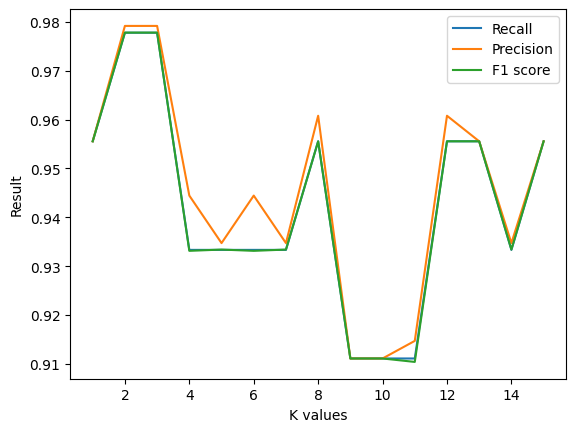

Best k
Recall:  2
Precision:  2
F1-Score:  2


In [30]:
best_k = tvt_test(15, x_train, x_val, y_train, y_val)

#### retrain the model using the best k

In [31]:
x_train_total = pd.concat([x_train, x_val], ignore_index=True)
y_train_total = pd.concat([y_train, y_val], ignore_index=True)

In [32]:
model = KNeighborsClassifier(n_neighbors=best_k)
model.fit(x_train_total, y_train_total)
y_pred = model.predict(x_test)

Recall: 1.0
Precision: 1.0
F-Score: 1.0


<Figure size 640x480 with 0 Axes>

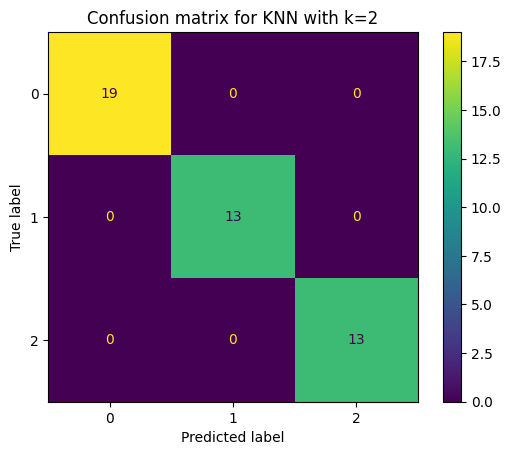

array([[19,  0,  0],
       [ 0, 13,  0],
       [ 0,  0, 13]], dtype=int64)

In [33]:
print('Recall:', calculate_recall(y_test, y_pred, 'weighted'))
print('Precision:', calculate_precision(y_test, y_pred, 'weighted'))
print('F-Score:', calculate_f1(y_test, y_pred, 'weighted'))
calculate_confusion_matrix(y_test, y_pred, title=f'Confusion matrix for KNN with k={best_k}')

### 10 CV - multiple k values

********* Averages - k=1 **********
Recall: 0.9607936507936509
Precision: 0.9615079365079366
F1 Score: 0.9588337588337589
********* Averages - k=2 **********
Recall: 0.9541269841269842
Precision: 0.9548412698412698
F1 Score: 0.9514263514263513
********* Averages - k=3 **********
Recall: 0.9663492063492064
Precision: 0.9738095238095238
F1 Score: 0.964938764938765
********* Averages - k=4 **********
Recall: 0.9663492063492064
Precision: 0.9738095238095238
F1 Score: 0.964938764938765
********* Averages - k=5 **********
Recall: 0.9730158730158731
Precision: 0.9785714285714285
F1 Score: 0.9712065712065712
********* Averages - k=6 **********
Recall: 0.9596825396825397
Precision: 0.9671428571428572
F1 Score: 0.9575313575313575
********* Averages - k=7 **********
Recall: 0.9552380952380953
Precision: 0.9585714285714285
F1 Score: 0.9487991637991638
********* Averages - k=8 **********
Recall: 0.9735714285714286
Precision: 0.979047619047619
F1 Score: 0.973870573870574
********* Averages - k=9 ***

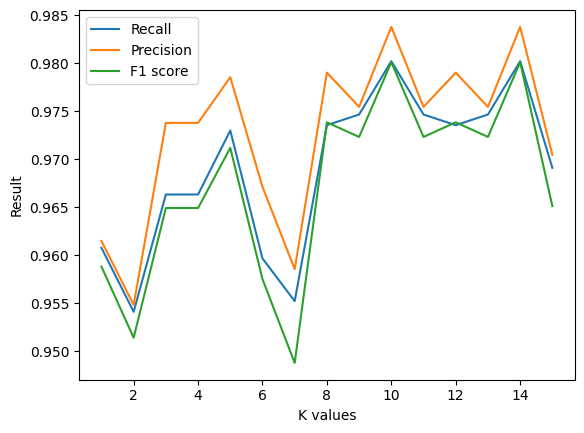

Best k
Recall:  10
Precision:  10
F1-Score:  10


In [34]:
best_k_cv = cross_validation_test(15, X, y, k_folds=10)

Como se pode observar, o k=10 é o obtem melhores resultados na classificação dos modelos. Assim, o modelo será novamente re-treinado utilizando este valor

In [35]:
# TODO: verificar como re-treinar o modelo

KNN - com um K pequeno, o modelo fica mais sensivel a ruido e a overfitting
Quando usamos um K grande, fica pouco sensivel

Usar k impar sempre que temos um numero classes par 

## ReliefF - Ex.2.2

In [22]:
from skfeature.function.similarity_based import fisher_score, reliefF

In [57]:
def plot_elbow(f1_scores, k_model, metric, title=None):
    f1_scores = [0] + f1_scores
    plt.figure()
    plt.plot(np.arange(len(f1_scores)), f1_scores, '*-')
    plt.ylim(0, 1)
    plt.xlim(0, len(f1_scores))
    if title is not None:
        plt.title(f'Plot with the features used, using the model KNN with k={k_model}, features ranked using {metric}')
    else:
        plt.title(title)
    plt.ylabel(f'F1 score')
    plt.xlabel(f'Nº features used')
    plt.show()

In [24]:
def order_features(x_train, y_train, metric='reliefF'):
    if metric == 'reliefF':
        # ReliefF
        print('reliefF')
        score = reliefF.reliefF(x_train.to_numpy(), y_train.to_numpy())
    else:
        # fisher
        print('fisher')
        score = fisher_score.fisher_score(x_train.to_numpy(), y_train.to_numpy())
    
    features_ranked = (-score).argsort()
    features = x_train.columns

    print(f'Features ranked by {metric}:')
    print(list(features[features_ranked]))
    print(f'Scores:')
    print(score)

    return list(features[features_ranked])

In [25]:
def best_model_feature_and_k(x_train, x_val, y_train, y_val, features, function='ReliefF', plot=False):
    df = pd.DataFrame()

    max_score = 0
    best_k = 0
    best_n_features = 0

    for k in range(15):
        f1_scores = []
        for n_features in range(1, len(features)+1):
            features_to_use = features[:n_features]
            model = KNeighborsClassifier(n_neighbors=k+1)
            model.fit(x_train[features_to_use], y_train)
            y_pred = model.predict(x_val[features_to_use])
            f1 = calculate_f1(y_val, y_pred,  'weighted')
            if f1 > max_score:
                max_score = f1
                best_k = k+1
                best_n_features = n_features
            f1_scores.append(f1)
        df[f'K{k+1}'] = pd.Series(np.array(f1_scores))
        if plot:
            plot_elbow(f1_scores, k+1, function)
    df = df.set_index(np.arange(1, len(features)+1))
    print('Max f1-score: ', max_score)
    print('Model used: ', best_k)
    print('Best number features:', best_n_features)
    return df, best_k, best_n_features

In [16]:
x_train, x_val, x_test, y_train, y_val, y_test = split_train_test_validation(X, y)

NameError: name 'X' is not defined

In [41]:
relieff_features = order_features(x_train, y_train)

reliefF
Features ranked by reliefF:
['petal length (cm)', 'petal width (cm)', 'sepal length (cm)', 'sepal width (cm)']
Scores:
[188.54409091  89.84818182 575.7025     248.48818182]


In [42]:
results, best_k, best_n_features_relief = best_model_feature_and_k(x_train, x_val, y_train, y_val, relieff_features, plot=False)

Max f1-score:  0.9777530589543938
Model used:  2
Best number features: 2


In [43]:
results

,K1,K2,K3,K4,K5,K6,K7,K8,K9,K10,K11,K12,K13,K14,K15
1,0.909502,0.910714,0.932660,0.932660,0.932660,0.932660,0.932660,0.932660,0.932660,0.932660,0.932660,0.932660,0.932660,0.977753,0.932660
2,0.955357,0.977753,0.977753,0.977753,0.977753,0.955556,0.955556,0.955556,0.977753,0.955556,0.977753,0.955556,0.977753,0.977753,0.977753
3,0.955357,0.977753,0.955357,0.955357,0.955357,0.977753,0.955357,0.977753,0.955357,0.977753,0.977753,0.977753,0.977753,0.955556,0.933259
4,0.955357,0.955357,0.955357,0.933259,0.955357,0.955556,0.977753,0.977753,0.955357,0.977753,0.955357,0.977753,0.932660,0.933259,0.932660


#### retrain best model

In [44]:
x_train_total = pd.concat([x_train, x_val], ignore_index=True)
y_train_total = pd.concat([y_train, y_val], ignore_index=True)

In [45]:
features_to_use = relieff_features[:best_n_features_relief]
model = KNeighborsClassifier(n_neighbors=best_k)
model.fit(x_train_total[features_to_use], y_train_total)
y_pred = model.predict(x_test[features_to_use])

Recall: 0.9777777777777777
Precision: 0.9793650793650793
F-Score: 0.9777448559670783


<Figure size 640x480 with 0 Axes>

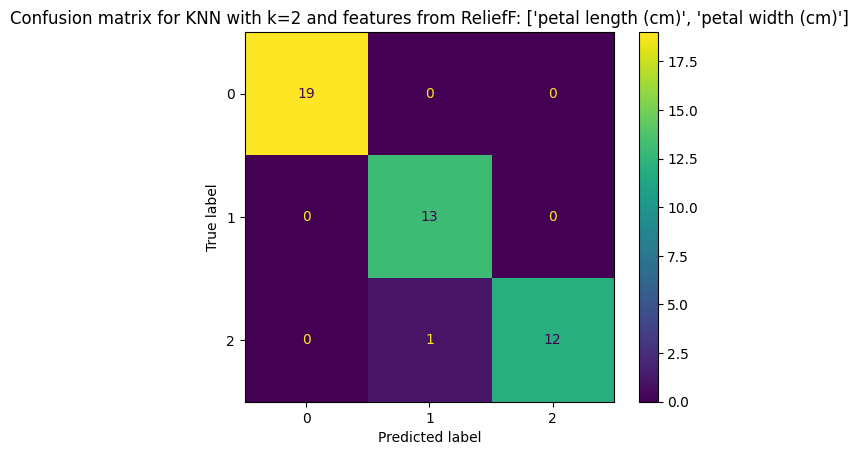

array([[19,  0,  0],
       [ 0, 13,  0],
       [ 0,  1, 12]], dtype=int64)

In [46]:
print('Recall:', calculate_recall(y_test, y_pred, 'weighted'))
print('Precision:', calculate_precision(y_test, y_pred, 'weighted'))
print('F-Score:', calculate_f1(y_test, y_pred, 'weighted'))
calculate_confusion_matrix(y_test, y_pred, title=f'Confusion matrix for KNN with k={best_k} and features from ReliefF: {features_to_use}')

## Fisher Score - Ex.2.3

In [47]:
x_train, x_val, x_test, y_train, y_val, y_test = split_train_test_validation(X, y)

In [48]:
fisher_features = order_features(x_train, y_train, 'fisher')

fisher
Features ranked by fisher:
['petal length (cm)', 'petal width (cm)', 'sepal length (cm)', 'sepal width (cm)']
Scores:
[ 1.48085274  0.71441594 18.63261689 12.71434843]


In [49]:
results, best_k, best_n_features_fisher = best_model_feature_and_k(x_train, x_val, y_train, y_val, fisher_features, plot=False)

Max f1-score:  0.9778760192553295
Model used:  4
Best number features: 2


In [50]:
results

,K1,K2,K3,K4,K5,K6,K7,K8,K9,K10,K11,K12,K13,K14,K15
1,0.955867,0.909809,0.866667,0.909809,0.932912,0.909809,0.932912,0.932912,0.955867,0.932912,0.932912,0.932912,0.932912,0.932912,0.932912
2,0.933628,0.907744,0.955867,0.977876,0.977876,0.955556,0.955867,0.955867,0.955867,0.932912,0.955867,0.955867,0.955867,0.955867,0.955867
3,0.911111,0.911111,0.955867,0.955867,0.955867,0.955867,0.955867,0.955867,0.955867,0.955867,0.955867,0.955867,0.933856,0.933856,0.933856
4,0.911735,0.932912,0.955867,0.977876,0.955867,0.955867,0.955867,0.955867,0.955867,0.955867,0.933856,0.955867,0.933856,0.933856,0.933856


#### retrain best model

In [51]:
x_train_total = pd.concat([x_train, x_val], ignore_index=True)
y_train_total = pd.concat([y_train, y_val], ignore_index=True)

In [52]:
features_to_use = fisher_features[:best_n_features_fisher]
model = KNeighborsClassifier(n_neighbors=best_k)
model.fit(x_train_total[features_to_use], y_train_total)
y_pred = model.predict(x_test[features_to_use])

Recall: 1.0
Precision: 1.0
F-Score: 1.0


<Figure size 640x480 with 0 Axes>

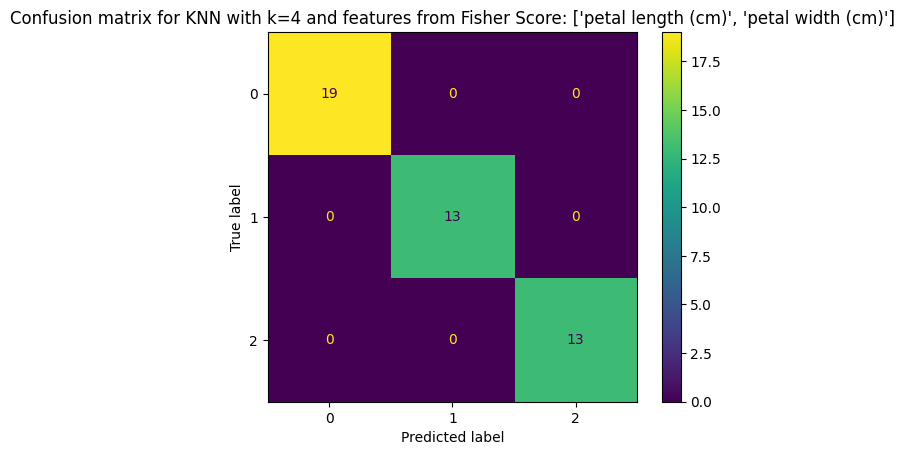

array([[19,  0,  0],
       [ 0, 13,  0],
       [ 0,  0, 13]], dtype=int64)

In [53]:
print('Recall:', calculate_recall(y_test, y_pred, 'weighted'))
print('Precision:', calculate_precision(y_test, y_pred, 'weighted'))
print('F-Score:', calculate_f1(y_test, y_pred, 'weighted'))
calculate_confusion_matrix(y_test, y_pred, title=f'Confusion matrix for KNN with k={best_k} and features from Fisher Score: {features_to_use}')

## Ex 2.4 - restrict classes

In [83]:
indexes_setosa = pd.Series(y[y==0].index)
indexes_versicolor = pd.Series(y[y == 1].index).sample(30)
indexes_virginica = pd.Series(y[y==2].index).sample(10)

In [84]:
new_X = pd.concat([X.loc[indexes_setosa], X.loc[indexes_versicolor], X.loc[indexes_virginica]], ignore_index=True)
new_y = pd.concat([y[indexes_setosa], y[indexes_versicolor], y[indexes_virginica]], ignore_index=True)

In [85]:
x_train, x_val, x_test, y_train, y_val, y_test = split_train_test_validation(new_X, new_y)

In [86]:
fisher_features = order_features(x_train, y_train, 'fisher')

fisher
Features ranked by fisher:
['petal length (cm)', 'petal width (cm)', 'sepal length (cm)', 'sepal width (cm)']
Scores:
[ 2.13430458  0.48559808 40.45606818 18.16360235]


In [87]:
results, best_k, best_n_features = best_model_feature_and_k(x_train, x_val, y_train, y_val, fisher_features, plot=False)

Max f1-score:  1.0
Model used:  1
Best number features: 2


In [88]:
results

,K1,K2,K3,K4,K5,K6,K7,K8,K9,K10,K11,K12,K13,K14,K15
1,0.963931,0.925926,0.963931,0.961292,0.961292,0.961292,0.961292,0.791246,0.791246,0.791246,0.791246,0.791246,0.791246,0.791246,0.791246
2,1.000000,1.000000,1.000000,0.961292,0.961292,0.961292,0.961292,0.791246,0.791246,0.791246,0.791246,0.791246,0.791246,0.791246,0.791246
3,0.963931,0.925926,0.963931,1.000000,1.000000,0.917284,0.917284,0.791246,0.791246,0.791246,0.791246,0.791246,0.791246,0.791246,0.791246
4,0.963931,0.925926,0.963931,0.961292,0.961292,0.863492,0.863492,0.791246,0.791246,0.791246,0.791246,0.791246,0.791246,0.791246,0.791246


#### retrain best model

In [89]:
x_train_total = pd.concat([x_train, x_val], ignore_index=True)
y_train_total = pd.concat([y_train, y_val], ignore_index=True)

In [90]:
features_to_use = fisher_features[:best_n_features]
model = KNeighborsClassifier(n_neighbors=best_k)
model.fit(x_train_total[features_to_use], y_train_total)
y_pred = model.predict(x_test[features_to_use])

Recall: 0.9629629629629629
Precision: 0.9753086419753086
F-Score: 0.9655773420479302


<Figure size 640x480 with 0 Axes>

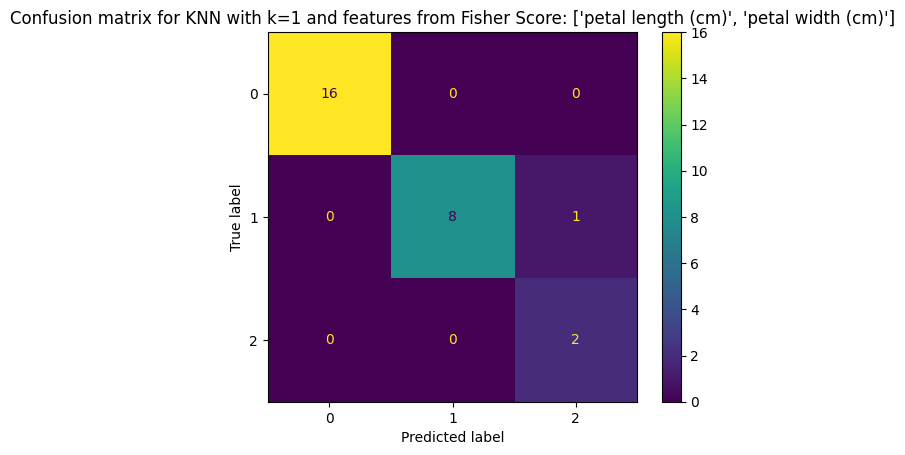

array([[16,  0,  0],
       [ 0,  8,  1],
       [ 0,  0,  2]], dtype=int64)

In [91]:
print('Recall:', calculate_recall(y_test, y_pred, 'weighted'))
print('Precision:', calculate_precision(y_test, y_pred, 'weighted'))
print('F-Score:', calculate_f1(y_test, y_pred, 'weighted'))
calculate_confusion_matrix(y_test, y_pred, title=f'Confusion matrix for KNN with k={best_k} and features from Fisher Score: {features_to_use}')

Verifica-se que pertubar as percentagens de cada tipo de flor, a performance do modelo diminui.

## Ex 3 - test models with human activities dataset

In [42]:
features_path = os.path.join('results', 'extracted_features.csv')

In [43]:
X = pd.read_csv(features_path)
y = X.pop('activity')

In [44]:
y.value_counts()

1     1830
5     1550
4     1541
6      996
3      952
2      946
7      499
13      85
8       64
10      62
11      61
9       58
14      40
12      39
15      21
16      19
Name: activity, dtype: int64

Como se pode aboservar, não existe uma distribuição uniforme das atividades, algumas atividades existem em mais abundância que outras, podendo prever já há partida que o modelo terá dificildade em classificar as atividades.

In [45]:
x_train, x_val, x_test, y_train, y_val, y_test = split_train_test_validation(X, y)

In [46]:
%%time
relieff_features = order_features(x_train, y_train)

reliefF
Features ranked by reliefF:
['are', 'magnetometer_y_energy', 'magnetometer_z_energy', 'gyroscope_y_energy', 'gyroscope_x_energy', 'gyroscope_z_energy', 'accelerometer_z_energy', 'magnetometer_x_energy', 'accelerometer_y_energy', 'accelerometer_x_energy', 'aae', 'gyroscope_x_variance', 'gyroscope_y_variance', 'gyroscope_z_variance', 'avg', 'gyroscope_x_df', 'gyroscope_y_df', 'gyroscope_z_df', 'gyroscope_y_interquantile', 'gyroscope_x_interquantile', 'gyroscope_y_rms', 'accelerometer_x_df', 'gyroscope_x_std', 'gyroscope_y_std', 'gyroscope_x_rms', 'accelerometer_z_df', 'gyroscope_y_median', 'accelerometer_z_mean_crossing_rate', 'gyroscope_y_mean', 'accelerometer_y_mean_crossing_rate', 'magnetometer_z_mean_crossing_rate', 'magnetometer_x_mean_crossing_rate', 'gyroscope_z_mean_crossing_rate', 'gyroscope_z_interquantile', 'gyroscope_x_mean_crossing_rate', 'gyroscope_y_mean_crossing_rate', 'magnetometer_y_mean_crossing_rate', 'accelerometer_x_mean_crossing_rate', 'magnetometer_x_df', 

In [47]:
%%time
results, best_k, best_n_features = best_model_feature_and_k(x_train, x_val, y_train, y_val, relieff_features, plot=False)

Max f1-score:  0.5912253891682612
Model used:  8
Best number features: 48
CPU times: total: 30min 7s
Wall time: 11min 59s


In [48]:
results

,K1,K2,K3,K4,K5,K6,K7,K8,K9,K10,K11,K12,K13,K14,K15
1,0.444972,0.445422,0.456973,0.468007,0.470853,0.472940,0.482984,0.481018,0.485018,0.490721,0.494194,0.493011,0.49090,0.484940,0.487815
2,0.444972,0.445422,0.456973,0.468007,0.470853,0.472940,0.482984,0.481018,0.485018,0.490721,0.494194,0.493011,0.49090,0.484940,0.487815
3,0.444972,0.445422,0.456973,0.468007,0.470853,0.472940,0.482984,0.481018,0.485018,0.490721,0.494194,0.493011,0.49090,0.484940,0.487815
4,0.444972,0.445422,0.456973,0.468007,0.470853,0.472940,0.482984,0.481018,0.485018,0.490721,0.494194,0.493011,0.49090,0.484940,0.487815
5,0.444972,0.445422,0.456973,0.468007,0.470853,0.472940,0.482984,0.481018,0.485018,0.490721,0.494194,0.493011,0.49090,0.484940,0.487815
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168,0.567549,0.571033,0.576169,0.585551,0.580962,0.575573,0.589040,0.588522,0.586662,0.583779,0.586259,0.589620,0.58681,0.584502,0.585899
169,0.567549,0.571033,0.576169,0.585551,0.580962,0.575573,0.589040,0.588522,0.586662,0.583779,0.586259,0.589620,0.58681,0.584502,0.585899
170,0.567549,0.571033,0.576169,0.585551,0.580962,0.575573,0.589040,0.588522,0.586662,0.583779,0.586259,0.589620,0.58681,0.584502,0.585899
171,0.567549,0.571033,0.576169,0.585551,0.580962,0.575573,0.589040,0.588522,0.586662,0.583779,0.586259,0.589620,0.58681,0.584502,0.585899


#### retrain best model

In [49]:
x_train_total = pd.concat([x_train, x_val], ignore_index=True)
y_train_total = pd.concat([y_train, y_val], ignore_index=True)

In [50]:
features_to_use = relieff_features[:best_n_features]
model = KNeighborsClassifier(n_neighbors=best_k)
model.fit(x_train_total[features_to_use], y_train_total)
y_pred = model.predict(x_test[features_to_use])

Recall: 0.599087105363256
Precision: 0.5598269819454456
F-Score: 0.576534570909447


c:\Users\joana\anaconda3\envs\cl_human_activities\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

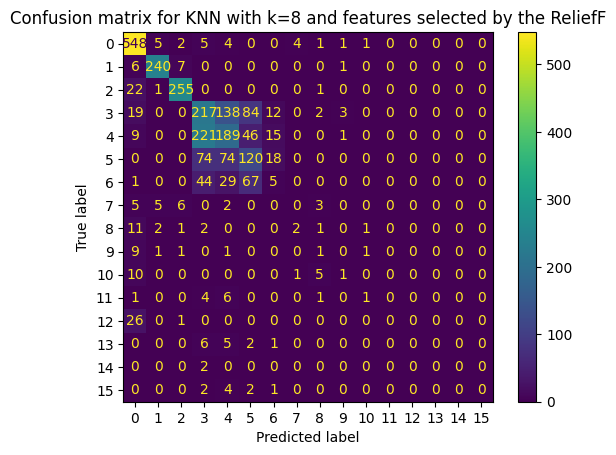

array([[548,   5,   2,   5,   4,   0,   0,   4,   1,   1,   1,   0,   0,
          0,   0,   0],
       [  6, 240,   7,   0,   0,   0,   0,   0,   0,   1,   0,   0,   0,
          0,   0,   0],
       [ 22,   1, 255,   0,   0,   0,   0,   0,   1,   0,   0,   0,   0,
          0,   0,   0],
       [ 19,   0,   0, 217, 138,  84,  12,   0,   2,   3,   0,   0,   0,
          0,   0,   0],
       [  9,   0,   0, 221, 189,  46,  15,   0,   0,   1,   0,   0,   0,
          0,   0,   0],
       [  0,   0,   0,  74,  74, 120,  18,   0,   0,   0,   0,   0,   0,
          0,   0,   0],
       [  1,   0,   0,  44,  29,  67,   5,   0,   0,   0,   0,   0,   0,
          0,   0,   0],
       [  5,   5,   6,   0,   2,   0,   0,   0,   3,   0,   0,   0,   0,
          0,   0,   0],
       [ 11,   2,   1,   2,   0,   0,   0,   2,   1,   0,   1,   0,   0,
          0,   0,   0],
       [  9,   1,   1,   0,   1,   0,   0,   0,   1,   0,   1,   0,   0,
          0,   0,   0],
       [ 10,   0,   0,   0,   

In [51]:
print('Recall:', calculate_recall(y_test, y_pred, 'weighted'))
print('Precision:', calculate_precision(y_test, y_pred, 'weighted'))
print('F-Score:', calculate_f1(y_test, y_pred, 'weighted'))
calculate_confusion_matrix(y_test, y_pred, title=f'Confusion matrix for KNN with k={best_k} and features selected by the ReliefF')

## Ex.4 - Neural Network

In [52]:
from sklearn.neural_network import MLPClassifier

In [53]:
%%time
#relieff_features = order_features(x_train, y_train)

CPU times: total: 0 ns
Wall time: 0 ns


In [54]:
def best_model(x_train, x_val, y_train, y_val, features, function='ReliefF', plot=False):
    max_score = 0
    best_k = 0
    for units in range(10, 3*len(features),10):
        model = MLPClassifier(hidden_layer_sizes=(units,), activation='logistic', learning_rate='constant', max_iter=500)
        model.fit(x_train[features], y_train)
        y_pred = model.predict(x_val[features])
        f1 = calculate_f1(y_val, y_pred,  'weighted')
        if f1 > max_score:
            max_score = f1
            best_k = units
    print('Max f1-score: ', max_score)
    print('Model used: ', best_k)
    return  best_k

In [55]:
%%time
best_model(x_train, x_val, y_train, y_val, relieff_features[:best_n_features])

Max f1-score:  0.3421035354944654
Model used:  90
CPU times: total: 27.2 s
Wall time: 1min 23s


90